# 📂 2. Preperation
The first step is to bring in our data and store it in the right place. Therefore you could upload your dataset as .zip to the files area.
We like to store the data as explained in the preperation.md in chapter 2 (Preperation). Therefore you could simply execute the commands below.
In general you will find all information about the data etc. in the GitHub-Repo under 2_Preperation.

In [ ]:
# Unzip the data and extract it to the dataset directory. To see the folder you need to refresh the file area!
!unzip archive.zip -d dataset

In [ ]:
# Now we move the subfolder xray_dataset_covid19 out of the dataset folder and move the content back.
!mv dataset/xray_dataset_covid19 .
!mv xray_dataset_covid19/* dataset/

In [ ]:
# Last but not least we delete the unessecary folder xray_dataset_covid19
!rm -r xray_dataset_covid19/

### ✅ Well done!
Mission completed! We have successfully positioned our data so that we could move on to chapter 3 (Data Exploration).

# 👀 3. Data exploration
Now as we loaded our data in we would like to familiarize us with the given dataset from Kaggle. Therefore we take a look at the dataset folder and see two folders train and test with 2 subfolders NORMAL and PNEUNOMIA each. Inside of the folder are many images. But to work with it we have to take a look at least at 3 questions:  
- Are the images equally distributed?
- Does every image have the same size?
- Are they colored ore in grayscale format?  
  
So let´s find out.

## 3.1. Import needed dependencies, get the image urls and define some constants

In [ ]:
# Import opencv to handle image actions like resizing, grayscaling or displaying
# In google colab python-opencv is already installed. If you are not working inside of google colab you need to install it via pip first.
# It is recommended to use a python virtual environment if you are not inside google colab!
import cv2

# Import matplotlib.pyplot for data visualization. The naming as plt is shorter and an inofficial standard.
# In google colab matplotlib is already installed. If you are not working inside of google colab you need to install it via pip first.
import matplotlib.pyplot as plt

# Import numpy - a better array library
import numpy as np

# Import glob to get the url via regex
import glob

In [ ]:
# Define the classes we want to classify alphanumeric inside of an array as a constant
# Later on we would map the predicted index on it because the neural network could only work with numeric values 
CLASSES = ['NORMAL', 'PNEUMONIA']

# Define the image paths where we fetch our images.
IMAGE_PATHS = [
  '/content/dataset/train/NORMAL',
  '/content/dataset/train/PNEUMONIA',
  '/content/dataset/test/NORMAL',
  '/content/dataset/test/PNEUMONIA'
]

In [ ]:
def get_image_urls(image_path: str) -> list:
  '''
  Function to get the image urls
  '''

  # Initialize some empty arrays
  image_urls = []

  # Loop through the image path and fetch all files with the wildcard name *.* 
  # -> In our case all of them are images
  for image_url in glob.glob(f'{image_path}/*.*'):
    image_urls.append(image_url)
  
  return image_urls

In [ ]:
# Collect all image urls for images without pneumonia
NORMAL_TRAIN_URLS = get_image_urls(IMAGE_PATHS[0])
NORMAL_TEST_URLS = get_image_urls(IMAGE_PATHS[2])

# Collect all image urls for images with pneumonia
PNEUMONIA_TRAIN_URLS = get_image_urls(IMAGE_PATHS[1])
PNEUMONIA_TEST_URLS = get_image_urls(IMAGE_PATHS[3])

## 3.2 Visualize the distribution
As we now have our image urls we would like to display the distribution inside a bar chart. Therefore we use matplotlib.

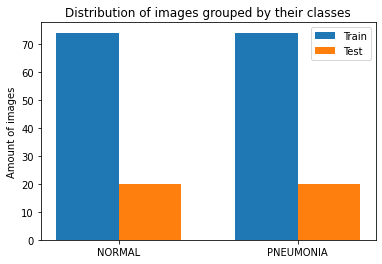

In [ ]:
# Generate the data arrays for our columns (Reduce the url list to the length)
train_columns = [len(NORMAL_TRAIN_URLS), len(PNEUMONIA_TRAIN_URLS)]
test_columns = [len(NORMAL_TEST_URLS), len(PNEUMONIA_TEST_URLS)]

# Generate a new subplot with matplotlib
figure, axis = plt.subplots()

# Arange classes to numeric array to specify the distribution on the x axis
x = np.arange(len(CLASSES))

# Define the width of the columns
width = 0.35

# Set the bars
rects1 = axis.bar(x - width/2, train_columns, width, label="Train")
rects2 = axis.bar(x + width/2, test_columns, width, label="Test")

# Define some labels
axis.set_ylabel("Amount of images")
axis.set_title("Distribution of images grouped by their classes")
axis.set_xticks(x)
axis.set_xticklabels(CLASSES)

# Activate the legend
axis.legend()

# Show the plot
plt.show()

### ✅ Awesome!
Now we know that the images are equally distributed! That is how we need it. But let´s take a look at our train/test ratio. A split of 70% / 30% would be ideal for most use cases but it depends on the problem to solve. So let´s calculate the ratio.

In [ ]:
# Calculate the train/test ratio
RATIO = len(NORMAL_TEST_URLS) / len(NORMAL_TRAIN_URLS)
print(f'{round(RATIO * 100, 2)}% of the images are testing images.')

27.03% of the images are testing images.


### The train/test ratio
Now we could see that there is nearly an optimal ratio between train and test images. Thats very good. The validation (test) data is later used to determine how well the neural network will perform.

## 3.3. Show some images
The next step is to show some images to find out which size they have and if the size is the same at any image.

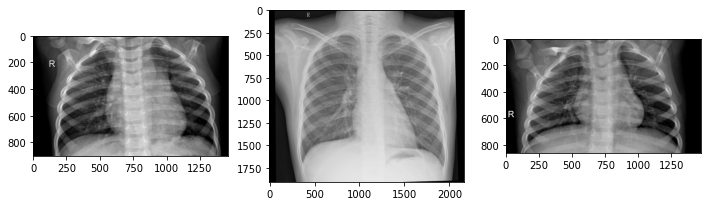

In [ ]:
# Define a plot with matplotlib
figure, axis = plt.subplots(1, 3, figsize=(10, 10))

# Use the tight layout to improve spacing between the different subplots
figure.tight_layout()

# Load the images
iteration = 0
for url in NORMAL_TRAIN_URLS[0:3]:
  img = cv2.imread(url)
  axis[iteration].imshow(img)

  iteration += 1

### 🖼 Different sizes
We see by showing the 3 different images that they are clearly not the same size. So we have to normalize in later on.

## 3.4 Get the image dimensions
Last but not least we need to know the dimensions of the image because later we would like to work with grayscale images. This has the advantage that we reduce the amount of inputs to calculate.

In [ ]:
# load the image
img = cv2.imread(PNEUMONIA_TRAIN_URLS[0])

# get the image shape
img.shape

(841, 1107, 3)

### ✅ Size found out
Well done! Now we know that at least one of the images is an RGB image with 3 dimensions. One for red, one for green and one for blue. So we will better normalize that also later.

# 4. 🛠 Normalization / Preprocessing
The 4th step is to preprocess the data. According to the data exploration we have to fix multiple things towards the data:  
- Reduce the shape to (width, height, 1) -> Grayscale
- Normalize the values between 0 and 1 -> Needed for better handling
- Resize the images to consistent sizes  
  
So let´s start.

In [ ]:
def load_images_and_labels(image_urls: list, class_index: int) -> tuple:
  '''
  Function to load the images as numpy array via opencv and build an array with the corresponding labels.
  It also preprocesses the images after loading
  '''
  images = []
  labels = []
  
  for url in image_urls:
    img = cv2.imread(url)

    # Set the color mode from BGR (Blue, Green, Red) to Grayscale. BGR because opencv import images as BGR not RGB!
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize the image to 250x250 px
    img = cv2.resize(img, (500, 500))

    # Normalize all values between 0 and 1; 255 because the color range is between 0 and 255
    img = img / 255

    images.append(img)
    labels.append(class_index)

  return images, labels

  


In [ ]:
# Load the images and labels for the normal images
NORMAL_TRAIN_IMAGES, NORMAL_TRAIN_LABELS = load_images_and_labels(NORMAL_TRAIN_URLS, 0)
NORMAL_TEST_IMAGES, NORMAL_TEST_LABELS = load_images_and_labels(NORMAL_TEST_URLS, 0)

# Load the images and labels for the pneumonia images
PNEUMONIA_TRAIN_IMAGES, PNEUMONIA_TRAIN_LABELS = load_images_and_labels(PNEUMONIA_TRAIN_URLS, 1)
PNEUMONIA_TEST_IMAGES, PNEUMONIA_TEST_LABELS = load_images_and_labels(PNEUMONIA_TEST_URLS, 1)

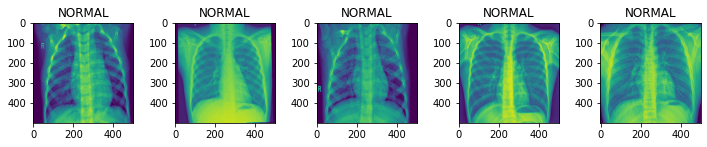

In [ ]:
#
# Plot some normal preprocessed images
#

# Define a plot with matplotlib
figure, axis = plt.subplots(1, 5, figsize=(10,10))

# Use the tight layout to improve spacing between the different subplots
figure.tight_layout()

# Load the images
iteration = 0
for img in NORMAL_TRAIN_IMAGES[0:5]:
  axis[iteration].imshow(img)
  axis[iteration].set_title('NORMAL')

  iteration += 1

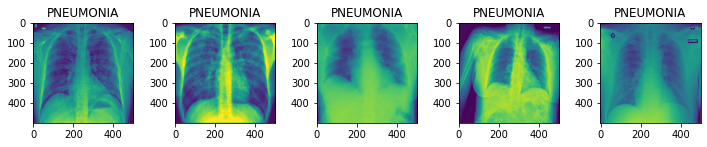

In [ ]:
#
# Plot some pneumonia preprocessed images
#

# Define a plot with matplotlib
figure, axis = plt.subplots(1, 5, figsize=(10,10))

# Use the tight layout to improve spacing between the different subplots
figure.tight_layout()

# Load the images
iteration = 0
for img in PNEUMONIA_TRAIN_IMAGES[0:5]:
  axis[iteration].imshow(img)
  axis[iteration].set_title('PNEUMONIA')

  iteration += 1

### ✅ Awesome!
Now we have successfully preprocessed our data, fetched the images and labels so that we could move on to the most interesting part - Building the model (neural network) with keras.

#5. 🏗 Build the model
The next step is to define our machine learning model. Therefore we would use the high level api Keras.

In [ ]:
# Import the Sequential class, which group a linear stack of layers into a machine learning model
from keras.models import Sequential

# Import some layers that we would use inside the model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D

In [ ]:
# Define a model
model = Sequential(name="Test")

# Add a convolutional layer with a feature size of 32
model.add(Conv2D(32, 3, 3, input_shape=(500, 500, 1)))

# Add a max pooling layer to point out the found features
model.add(MaxPool2D(2, 2))

# Add a convolutional layer with a feature size of 64
model.add(Conv2D(64, 3, 3))

# Add a max pooling layer to point out the found features
model.add(MaxPool2D(2, 2))

# Add a convolutional layer with a feature size of 128
model.add(Conv2D(128, 3, 3))

# Add a max pooling layer to point out the found features
model.add(MaxPool2D(2, 2))

# Add some dense layers - Dense layers are fully mashed layers where every neuron is connected to every neuron in the next layer.
# As activation function we will use the rectified linear unit function (ReLu)

# Flatten the input
model.add(Flatten())

# Layer with 10 neurons
model.add(Dense(10, activation="relu"))

# Layer with 5 neurons
model.add(Dense(5, activation="relu"))

# Layer with 2 neurons
model.add(Dense(2, activation="softmax"))

## 5.1 Compiling
Now we need to compile the model. That means we need to specify the loss function that we want to use, which metrics we want to track and how the model should be optimized.

In [ ]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [ ]:
# Summarize the model
model.summary() 

Model: "Test"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 166, 166, 32)      320       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 83, 83, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 27, 27, 64)        18496     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 2, 2, 128)        0      

## 5.2 Callbacks
To track the performance of our model we use Tensorboard, which is registered inside a callback. But callbacks could also be other things like an early stopping mode, where the model stops if there is no more learning success. But you could also specify own callbacks.

In [ ]:
# Import the tensorboard callback
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import TensorBoard, EarlyStopping

CALLBACKS = []

# Append a TensorBoard callback to display some metrics later on
# More information on parameters: https://keras.io/api/callbacks/tensorboard/
CALLBACKS.append(TensorBoard(    
    log_dir="logs",
    histogram_freq=0,
    write_graph=True,
    write_images=True,
    write_steps_per_second=False,
    update_freq="epoch",
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=None,
))

# Append an EarlyStopping callback to exit from training if there is only minimal change
# More information on parameters: https://keras.io/api/callbacks/early_stopping/
CALLBACKS.append(EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=2,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
))

## 5.3 Training
Now we would fit our model to the data

In [ ]:
# Build the data Arrays for training by merging the images and labels of both classes
TRAIN_IMAGES = NORMAL_TRAIN_IMAGES + PNEUMONIA_TRAIN_IMAGES
TRAIN_LABELS = NORMAL_TRAIN_LABELS + PNEUMONIA_TRAIN_LABELS

# Build the data Arrays for testing by merging the images and labels of both classes
TEST_IMAGES = NORMAL_TEST_IMAGES + PNEUMONIA_TEST_IMAGES
TEST_LABELS = NORMAL_TEST_LABELS + PNEUMONIA_TEST_LABELS

# Convert data arrays to numpy arrays
TRAIN_IMAGES = np.array(TRAIN_IMAGES)
TRAIN_LABELS = np.array(TRAIN_LABELS)
TEST_IMAGES = np.array(TEST_IMAGES)
TEST_LABELS = np.array(TEST_LABELS)

# Reshape the Image Arrays to match the Batch shape
TRAIN_IMAGES = TRAIN_IMAGES.reshape(len(TRAIN_IMAGES), 500, 500, 1)
TEST_IMAGES = TEST_IMAGES.reshape(len(TEST_IMAGES), 500, 500, 1)

# Train the model...
model.fit(TRAIN_IMAGES, TRAIN_LABELS, validation_data=(TEST_IMAGES, TEST_LABELS), callbacks=CALLBACKS, epochs=50, shuffle=True)

Epoch 1/50
5/5 [==============================] - 3s 526ms/step - loss: 0.7013 - accuracy: 0.5000 - val_loss: 0.6964 - val_accuracy: 0.5000
Epoch 2/50
5/5 [==============================] - 2s 452ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6905 - val_accuracy: 0.5000
Epoch 3/50
5/5 [==============================] - 2s 481ms/step - loss: 0.6842 - accuracy: 0.5000 - val_loss: 0.6707 - val_accuracy: 0.8000
Epoch 4/50
5/5 [==============================] - 2s 452ms/step - loss: 0.6683 - accuracy: 0.8311 - val_loss: 0.6340 - val_accuracy: 0.9250
Epoch 5/50
5/5 [==============================] - 2s 444ms/step - loss: 0.6353 - accuracy: 0.8446 - val_loss: 0.5637 - val_accuracy: 1.0000
Epoch 6/50
5/5 [==============================] - 2s 476ms/step - loss: 0.5587 - accuracy: 0.8986 - val_loss: 0.4400 - val_accuracy: 1.0000
Epoch 7/50
5/5 [==============================] - 2s 439ms/step - loss: 0.4099 - accuracy: 0.9054 - val_loss: 0.2852 - val_accuracy: 0.9500
Epoch 8/50
5/5 [====

In [ ]:
# Load the tensorboard extension to display logs
%load_ext tensorboard

# Run tensorboard
%tensorboard --logdir logs

# ✅ Nice!
Now we have our model successfully trained and could evaluate it with the tensorboard metrics. Let´s give it a try and predict an image the net didn´t know!

In [ ]:
# Let´s make some predictions!
# To test this you could simply upload some xray images, change the imread path and check if the network performs well.

# Load the test image that was uploaded
img = cv2.imread('/content/test_images/normal.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (500, 500))

prediction = model.predict(np.array([img]))
print(CLASSES[np.argmax(prediction[0])])

NORMAL
